In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

from models import VGG
from train import train1Epoch
from datasetCreator import ImageSubset
torch.cuda.empty_cache()

import os
import cv2

In [2]:
os.listdir('../../..')

['public',
 '.ipython',
 '.conda',
 'teams',
 '.nv',
 '.local',
 '.jupyter',
 '.config',
 'private',
 '.cache',
 '.keras']

In [3]:
with open('../../../teams/dsc-180a---a14-[88137]/example.txt') as f:
    lines = f.readlines()

In [4]:
lines

['hey this is Yash\n']

In [5]:
test_csv = pd.read_csv('BNPP_DT_test_with_ages.csv')
valid_csv = pd.read_csv('BNPP_DT_val_with_ages.csv')
train_csv = pd.read_csv('BNPP_DT_train_with_ages.csv')
h5py = h5py.File('bnpp_frontalonly_1024_10.hdf5')
train_csv

,unique_key,bnpp_value_log,BNPP_weight,PNA_mask,PNA_wight_mask,BNP_value,age_at_sampletime
0,Flodure_51396672_img1,0.690196,1,None,1,4.9,45
1,Okepik_50995691_img1,0.690196,1,None,1,4.9,53
2,Kuesluco_51713925_img1,0.690196,1,None,1,4.9,54
3,Gumepra_51602745_img1,0.690196,1,None,1,4.9,58
4,Gapeklik_51060218_img1,0.690196,1,None,1,4.9,19
...,...,...,...,...,...,...,...
21369,Puesrueci_53095611_img1,4.845099,1,None,1,70000.1,57
21370,Adakas_52269723_img1,4.845099,1,None,1,70000.1,73
21371,Ekugud_52967627_img1,4.845099,1,None,1,70000.1,53
21372,Beguchouf_52038583_img1,4.845099,1,None,1,70000.1,60


In [6]:
train = train_csv[['unique_key','bnpp_value_log']]
train

,unique_key,bnpp_value_log
0,Flodure_51396672_img1,0.690196
1,Okepik_50995691_img1,0.690196
2,Kuesluco_51713925_img1,0.690196
3,Gumepra_51602745_img1,0.690196
4,Gapeklik_51060218_img1,0.690196
...,...,...
21369,Puesrueci_53095611_img1,4.845099
21370,Adakas_52269723_img1,4.845099
21371,Ekugud_52967627_img1,4.845099
21372,Beguchouf_52038583_img1,4.845099


#list(h5py.keys())
data = {}
ind=0
for key in list(h5py.keys()):
    image = Image.fromarray(f[key][:])
    #resizing to 224 x 224
    #formatted = (image * 255 / np.max(image)).astype('uint8')
    #img = Image.fromarray(formatted).resize((224,224))
    
    data[ind]=[key,image]
    #img_tensor = transform(img)
    #data[key] = img_tensor
    #img.save(f'data/images/{key}.jpg')

    ind+=1
data=pd.DataFrame(data).T
data.columns = ['patientID','image']
merged = data.merge(train, how='inner',left_on='patientID',right_on='unique_key')
merged

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
train_data = ImageSubset(csv_file = 'data/BNPP_DT_train_with_ages.csv', data=data, img_dir='data/images/')
train_data

In [7]:
batch_size = 8 #maybe change to 16, 8

# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

train_set = ImageSubset(csv_file = train_csv, h5py_file = h5py) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)

# valid_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

valid_set = ImageSubset(csv_file = valid_csv, h5py_file = h5py) #, transform = valid_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

print(train_set[0])
#print(iter(train_loader).next())
#print(train.__getitem__(0))

(tensor([[[0.0408, 0.0238, 0.0134,  ..., 0.0067, 0.0071, 0.0073],
         [0.0375, 0.0228, 0.0111,  ..., 0.0064, 0.0057, 0.0095],
         [0.0374, 0.0216, 0.0106,  ..., 0.0077, 0.0059, 0.0093],
         ...,
         [0.2559, 0.1940, 0.1389,  ..., 0.0757, 0.0761, 0.0763],
         [0.4298, 0.3650, 0.2968,  ..., 0.2172, 0.2197, 0.2223],
         [0.6933, 0.6342, 0.5987,  ..., 0.5284, 0.5373, 0.5556]]]), 3.669409867287782)


from torchvision.io import read_image
from torchvision.models import vgg16

img = read_image(train_set[0])

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

#example from Pytorch Website
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, num_workers=2)

#print(iter(training_loader).next(), training_loader)
#print(training_set.__getitem__(0))

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = VGG('VGG16').to(device)
model

cuda


VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

3.85  2.08  2.50  3.61  2.24  4.74  3.21  3.67


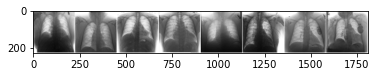

In [9]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(str('%.2f' % labels[j].item()) for j in range(batch_size)))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")
epochs = 10 #40-50 epochs

total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss()

# the optimizer
# need to tune optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)#, weight_decay=0.0005)

[INFO]: Computation device: cuda
[INFO]: 27,517,485 total parameters.
[INFO]: 27,517,485 trainable parameters.


# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        #print(data)

        image, bnpp = data
        image, bnpp = image.to(device), bnpp.to(device)
        print(image,bnpp)
        #print(i)
        #print(data)
        #print(data[0])
        #print(data[1])
        #print(data[2])
        #break
        image = image.to(device)
        bnpp = bnpp.to(device)

        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        #outputs = model(image.float())
        # calculate the loss
        loss = loss_fn(outputs, bnpp)
        train_running_loss += loss.item()
        # calculate the accuracy
        #_, preds = torch.max(outputs.data, 1)
        #train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()

    epoch_loss = train_running_loss / counter
    #epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss

In [11]:
len(train_loader)

71

In [12]:
torch.cuda.empty_cache()
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10
best_vloss = 1_000_000.

tlosses, vlosses=[],[]

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    for param in model.parameters():
        param.requires_grad = True
    
    avg_loss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader, writer)
    #print(avg_loss)
    #print(torch.cuda.memory_summary())
    # We don't need gradients on to do reporting
    for param in model.parameters():
        param.requires_grad = False
        
    model.train(False)

    running_vloss = 0.0
    for i, (vinputs,vlabels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        #vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs.squeeze(), vlabels).detach()
        running_vloss += vloss
        vinputs.detach()
        vlabels.detach()

    avg_vloss = running_vloss / (len(valid_loader))
    #print(torch.cuda.memory_summary())
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    tlosses.append(avg_loss)
    vlosses.append(avg_vloss)

    # Log the running loss averaged per batch
    # for both training and validation
    #writer.add_scalars('Training vs. Validation Loss',
    #                { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                epoch_number + 1)
    #writer.add_figure(tag='Train Loss',
    #                figure=plt.scatter(epoch,avg_loss))
    #writer.add_figure(tag='Validation Loss',
    #                figure=plt.scatter(epoch,avg_vloss))
    #writer.flush()

    # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = 'model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


  0%|          | 0/71 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 10/10 [00:00<00:00, 11.44it/s]


LOSS train 1.0797442130639519 valid 0.7731887698173523
EPOCH 2:


100%|██████████| 10/10 [00:00<00:00, 10.29it/s]


LOSS train 0.8812239144889402 valid 0.7638205289840698
EPOCH 3:


100%|██████████| 10/10 [00:00<00:00, 12.64it/s]


LOSS train 0.8284359377034953 valid 0.7593294978141785
EPOCH 4:


100%|██████████| 10/10 [00:00<00:00, 11.30it/s]


LOSS train 0.8046525070365046 valid 0.7477566003799438
EPOCH 5:


100%|██████████| 10/10 [00:00<00:00, 11.18it/s]


LOSS train 0.789803512919117 valid 0.7233332395553589
EPOCH 6:


100%|██████████| 10/10 [00:00<00:00, 11.16it/s]


LOSS train 0.7723125567738439 valid 0.7513575553894043
EPOCH 7:


100%|██████████| 10/10 [00:00<00:00, 11.19it/s]


LOSS train 0.744815921279746 valid 0.7196550369262695
EPOCH 8:


100%|██████████| 10/10 [00:00<00:00, 10.18it/s]


LOSS train 0.7241317512283862 valid 0.7084798812866211
EPOCH 9:


100%|██████████| 10/10 [00:00<00:00, 11.17it/s]


LOSS train 0.7393382808692018 valid 0.7558344006538391
EPOCH 10:


100%|██████████| 10/10 [00:00<00:00, 11.38it/s]

LOSS train 0.733371591064292 valid 0.7119999527931213


Text(0.5, 1.0, 'Losses for Training and Validation Data Throughout 50 Epochs')

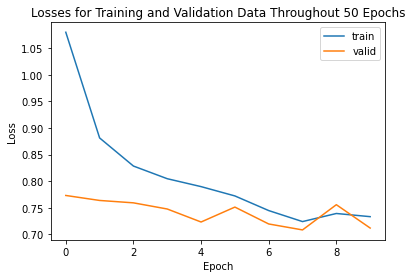

In [13]:
plt.plot(tlosses,label='train')
plt.plot(vlosses,label='valid')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses for Training and Validation Data Throughout 50 Epochs')

# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn,
            }, '../outputs/VGG16Reg.pth')
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../outputs/accuracy.jpg')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss.jpg')
plt.show()
 
print('TRAINING COMPLETE')

#to load saved model
saved_model = VGG()
saved_model.load_state_dict(torch.load(PATH))